<pre>网络中的网络（NiN）
Open the notebook in Colab
Open the notebook in SageMaker Studio Lab

LeNet、AlexNet和VGG都有一个共同的设计模式：通过一系列的卷积层与汇聚层来提取空间结构特征；然后通过全连接层对特征的表征进行处理。  
AlexNet和VGG对LeNet的改进主要在于如何扩大和加深这两个模块。   
或者，可以想象在这个过程的早期使用全连接层。  
然而，如果使用了全连接层，可能会完全放弃表征的空间结构。   
网络中的网络（NiN）提供了一个非常简单的解决方案：在每个像素的通道上分别使用多层感知机 (Lin et al., 2013)

<pre>NiN块

回想一下，卷积层的输入和输出由四维张量组成，张量的每个轴分别对应样本、通道、高度和宽度。  
另外，全连接层的输入和输出通常是分别对应于样本和特征的二维张量。  
NiN的想法是在每个像素位置（针对每个高度和宽度）应用一个全连接层。  
也就是每个高宽ij，遍历连接所有的chanel  
如果我们将权重连接到每个空间位置，我们可以将其视为1*1卷积层，或作为在每个像素位置上独立作用的全连接层。  
从另一个角度看，即将空间维度中的每个像素视为单个样本，将通道维度视为不同特征（feature）。

图7.3.1说明了VGG和NiN及它们的块之间主要架构差异。   
NiN块以一个普通卷积层开始，后面是两个1*1的卷积层。  
这两个1*1卷积层充当带有ReLU激活函数的逐像素全连接层。  
第一层的卷积窗口形状通常由用户设置。   
随后的卷积窗口形状固定为1*1。

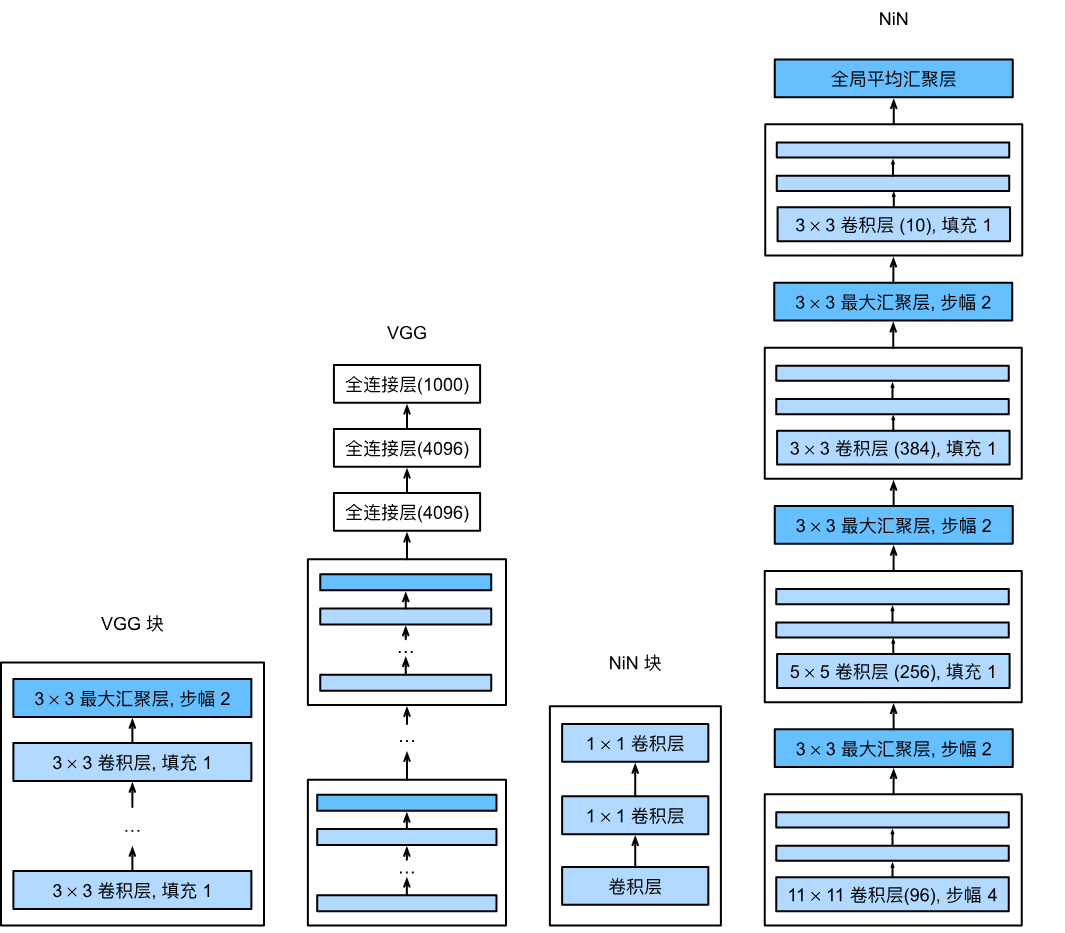

In [5]:
import torch
from torch import nn
from d2l import torch as d2l

# 输出形状由第一个卷积层决定 ((in_size-(k_size-1)+2*padding+strides-1)/strides)
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU())


<pre>NiN模型

最初的NiN网络是在AlexNet后不久提出的，显然从中得到了一些启示。  
NiN使用窗口形状为11*11、5*5和3*3的卷积层，输出通道数量与AlexNet中的相同。   
每个NiN块后有一个最大汇聚层，汇聚窗口形状为3*3，步幅为2(2,2组合减半，3,2不是减半)。

NiN和AlexNet之间的一个显著区别是NiN完全取消了全连接层。  
相反，NiN使用一个NiN块，其输出通道数等于标签类别的数量。  
最后放一个全局平均汇聚层（global average pooling layer），生成一个对数几率 （logits）。  
NiN设计的一个优点是，它显著减少了模型所需参数的数量。  
然而，在实践中，这种设计有时会增加训练模型的时间。

In [6]:
net = nn.Sequential(
    #1*224*224
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    #(224-(11-1)+2*0+4-1)/4=54
    nn.MaxPool2d(3, stride=2),
    # (54-(3-1)+2*0+2-1)/2=26
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    # (26-(5-1)+2*2+1-1)/1=26
    nn.MaxPool2d(3, stride=2),
    # (26-(3-1)+2*0+2-1)/2=12
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    # (12-(3-1)+2*1+1-1)/1=12
    nn.MaxPool2d(3, stride=2),
    # (12-(3-1)+2*0+2-1)/2=5
    nn.Dropout(0.5),
    # 标签类别数是10
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    # (5-(3-1)+2*1+1-1)/1=5
    nn.AdaptiveAvgPool2d((1, 1)),
    # batch_size*10*1*1
    # 将四维的输出转成二维的输出，其形状为(批量大小,10)
    nn.Flatten())


In [7]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)


Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


训练模型

和以前一样，我们使用Fashion-MNIST来训练模型。训练NiN与训练AlexNet、VGG时相似。

train_loss 0.995,test_loss 1.120, train acc 0.648, test acc 0.656
456.9 examples/sec on cuda:0


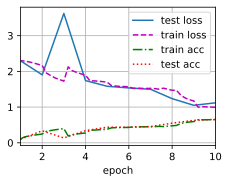

In [8]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())